## The data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

htb_green = "#9fef00"
node_black = "#141d2b"
hacker_grey = "#a4b1cd"
white = "#ffffff"
azure = "#0086ff"
nugget_yellow = "#ffaf00"
malware_red = "#ff3e3e"
vivid_purple = "#9f00ff"
aquamarine = "#2ee7b6"

# Configure plot styles
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update(
    {
        "figure.facecolor": node_black,
        "axes.facecolor": node_black,
        "axes.edgecolor": hacker_grey,
        "axes.labelcolor": white,
        "text.color": white,
        "xtick.color": hacker_grey,
        "ytick.color": hacker_grey,
        "grid.color": hacker_grey,
        "grid.alpha": 0.1,
        "legend.facecolor": node_black,
        "legend.edgecolor": hacker_grey,
        "legend.frameon": True,
        "legend.framealpha": 1.0,
        "legend.labelcolor": white,
    }
)

# Seed for reproducibility
SEED = 1337
np.random.seed(SEED)

print("Setup complete. Libraries imported and styles configured.")

Matplotlib is building the font cache; this may take a moment.


Setup complete. Libraries imported and styles configured.


In [4]:
# Generate synthetic data
n_samples = 1000
centers = [(0, 5), (5, 0)]  # Define centers for two distinct blobs
X, y = make_blobs(
    n_samples=n_samples,
    centers=centers,
    n_features=2,
    cluster_std=1.25,
    random_state=SEED,
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

print(f"Generated {n_samples} samples.")
print(f"Training set size: {X_train.shape[0]} samples.")
print(f"Testing set size: {X_test.shape[0]} samples.")
print(f"Number of features: {X_train.shape[1]}")
print(f"Classes: {np.unique(y)}")

Generated 1000 samples.
Training set size: 700 samples.
Testing set size: 300 samples.
Number of features: 2
Classes: [0 1]


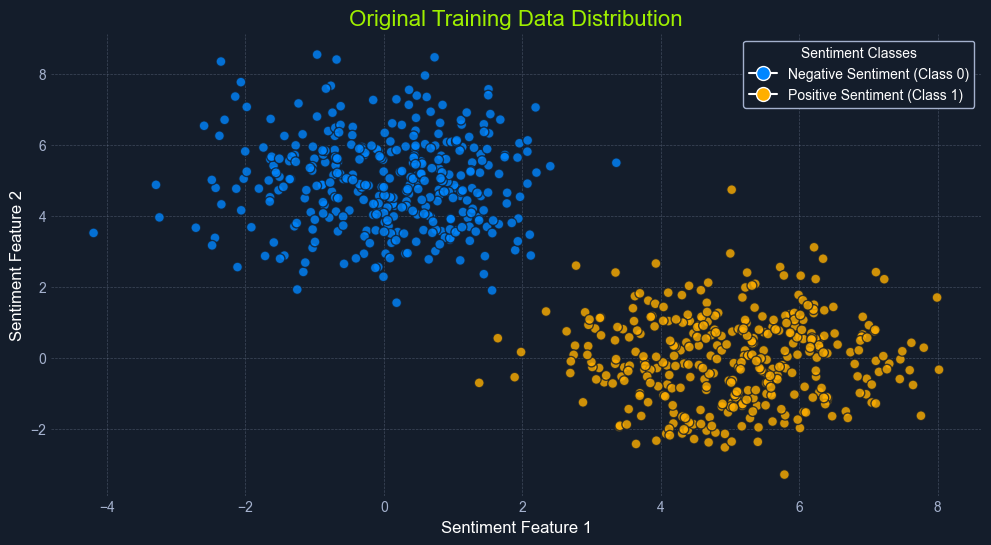

In [5]:
def plot_data(X, y, title="Dataset Visualization"):
    """
    Plots the 2D dataset with class-specific colors.

    Parameters:
    - X (np.ndarray): Feature data (n_samples, 2).
    - y (np.ndarray): Labels (n_samples,).
    - title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
        edgecolors=node_black,
        s=50,
        alpha=0.8,
    )
    plt.title(title, fontsize=16, color=htb_green)
    plt.xlabel("Sentiment Feature 1", fontsize=12)
    plt.ylabel("Sentiment Feature 2", fontsize=12)
    # Create a legend
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Negative Sentiment (Class 0)", 
            markersize=10,
            markerfacecolor=azure,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Positive Sentiment (Class 1)",
            markersize=10,
            markerfacecolor=nugget_yellow,
        ),
    ]
    plt.legend(handles=handles, title="Sentiment Classes")
    plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
    plt.show()


# Plot the data
plot_data(X_train, y_train, title="Original Training Data Distribution")

In [6]:
def plot_poisoned_data(
    X,
    y_original,
    y_poisoned,
    flipped_indices,
    title="Poisoned Data Visualization",
    target_class_info=None,
):
    """
    Plots a 2D dataset, highlighting points whose labels were flipped.

    Parameters:
    - X (np.ndarray): Feature data (n_samples, 2).
    - y_original (np.ndarray): The original labels before flipping (used for context if needed, currently unused in logic but good practice).
    - y_poisoned (np.ndarray): Labels after flipping.
    - flipped_indices (np.ndarray): Indices of the samples that were flipped.
    - title (str): The title for the plot.
    - target_class_info (int, optional): The class label of the points that were targeted for flipping. Defaults to None.
    """
    plt.figure(figsize=(12, 7))

    # Identify non-flipped points
    mask_not_flipped = np.ones(len(y_poisoned), dtype=bool)
    mask_not_flipped[flipped_indices] = False

    # Plot non-flipped points (color by their poisoned label, which is same as original)
    plt.scatter(
        X[mask_not_flipped, 0],
        X[mask_not_flipped, 1],
        c=y_poisoned[mask_not_flipped],
        cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
        edgecolors=node_black,
        s=50,
        alpha=0.6,
        label="Unchanged Label",  # Keep this generic
    )

    # Determine the label for flipped points in the legend
    if target_class_info is not None:
        flipped_legend_label = f"Flipped (Orig Class {target_class_info})"
        # You could potentially use target_class_info to adjust facecolor if needed,
        # but current logic colors by the new label which is often clearer.
    else:
        flipped_legend_label = "Flipped Label"

    # Plot flipped points with a distinct marker and outline
    if len(flipped_indices) > 0:
        # Color flipped points according to their new (poisoned) label
        plt.scatter(
            X[flipped_indices, 0],
            X[flipped_indices, 1],
            c=y_poisoned[flipped_indices],  # Color by the new label
            cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
            edgecolors=malware_red,  # Highlight edge in red
            linewidths=1.5,
            marker="X",  # Use 'X' marker
            s=100,
            alpha=0.9,
            label=flipped_legend_label,  # Use the determined label
        )

    plt.title(title, fontsize=16, color=htb_green)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)

    # Create legend
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 0 Point (Azure)",
            markersize=10,
            markerfacecolor=azure,
            linestyle="None",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 1 Point (Yellow)",
            markersize=10,
            markerfacecolor=nugget_yellow,
            linestyle="None",
        ),
        # Add the flipped legend entry using the label
        plt.Line2D(
            [0],
            [0],
            marker="X",
            color="w",
            label=flipped_legend_label,
            markersize=12,
            markeredgecolor=malware_red,
            markerfacecolor=hacker_grey,
            linestyle="None",
        ),
    ]
    plt.legend(handles=handles, title="Data Points")
    plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
    plt.show()

## Logistic Regression Model

Baseline Model Accuracy: 0.9933


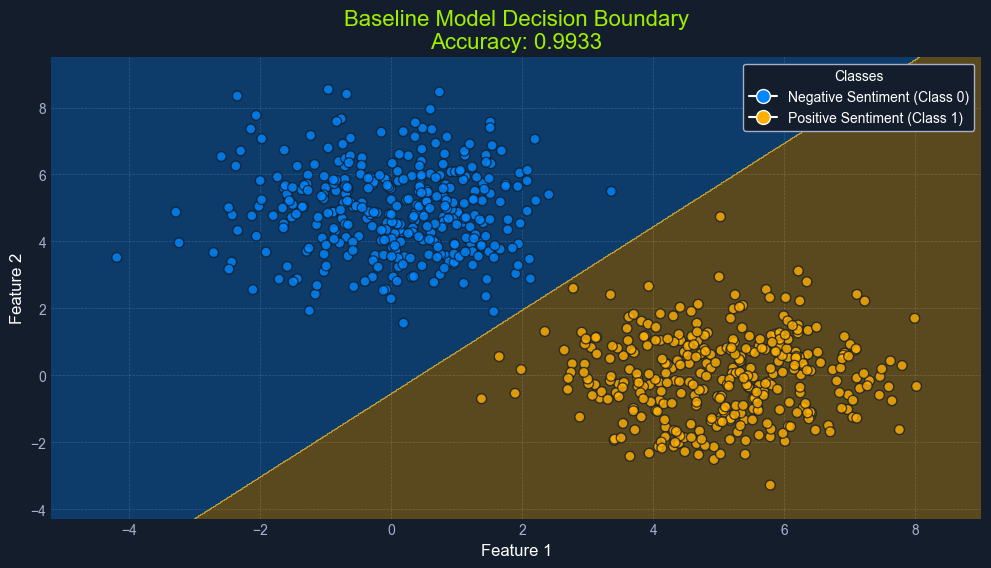

In [11]:
# Initialize and train the Logistic Regression model
baseline_model = LogisticRegression(random_state=SEED)
baseline_model.fit(X_train, y_train)

# Predict on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")


# Prepare to plot the decision boundary
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    Plots the decision boundary of a trained classifier on a 2D dataset.

    Parameters:
    - model: The trained classifier object (must have a .predict method).
    - X (np.ndarray): Feature data (n_samples, 2).
    - y (np.ndarray): Labels (n_samples,).
    - title (str): The title for the plot.
    """
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 6))
    # Plot the decision boundary contour
    plt.contourf(
        xx, yy, Z, cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]), alpha=0.3
    )

    # Plot the data points
    scatter = plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
        edgecolors=node_black,
        s=50,
        alpha=0.8,
    )

    plt.title(title, fontsize=16, color=htb_green)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)

    # Create a legend manually
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Negative Sentiment (Class 0)",
            markersize=10,
            markerfacecolor=azure,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Positive Sentiment (Class 1)",
            markersize=10,
            markerfacecolor=nugget_yellow,
        ),
    ]
    plt.legend(handles=handles, title="Classes")
    plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


# Plot the decision boundary for the baseline model
plot_decision_boundary(
    baseline_model,
    X_train,
    y_train,
    title=f"Baseline Model Decision Boundary\nAccuracy: {baseline_accuracy:.4f}",
)

## The Label Flipping Attack

The idea is to create a function that will take the original training labels and poision a percentage as input. It will randomly select the specified fraction of training data points and flip their labels

In [15]:
def flip_labels(y, poison_percentage):
    if not 0 <= poison_percentage <= 1:
        raise ValueError("poison_percentage must be between 0 and 1.")

    n_samples = len(y)
    n_to_flip = int(n_samples * poison_percentage)

    if n_to_flip == 0:
        print("Warning: Poison percentage is 0 or too low to flip any labels.")
        # Return unchanged labels and empty indices if no flips are needed
        return y.copy(), np.array([], dtype=int)

    # Use the defined SEED for the random number generator
    rng_instance = np.random.default_rng(SEED)
    # Select unique indices to flip
    flipped_indices = rng_instance.choice(n_samples, size=n_to_flip, replace=False)
    # Create a copy to avoid modifying the original array
    y_poisoned = y.copy()

    # Get the original labels at the indices we are about to flip
    original_labels_at_flipped = y_poisoned[flipped_indices]

    # Apply the flip: if original was 0, set to 1; otherwise (if 1), set to 0
    y_poisoned[flipped_indices] = np.where(original_labels_at_flipped == 0, 1, 0)

    print(f"Flipping {n_to_flip} labels ({poison_percentage * 100:.1f}%).")
    return y_poisoned, flipped_indices


--- Testing with 10% Poisoned Data ---
Flipping 70 labels (10.0%).


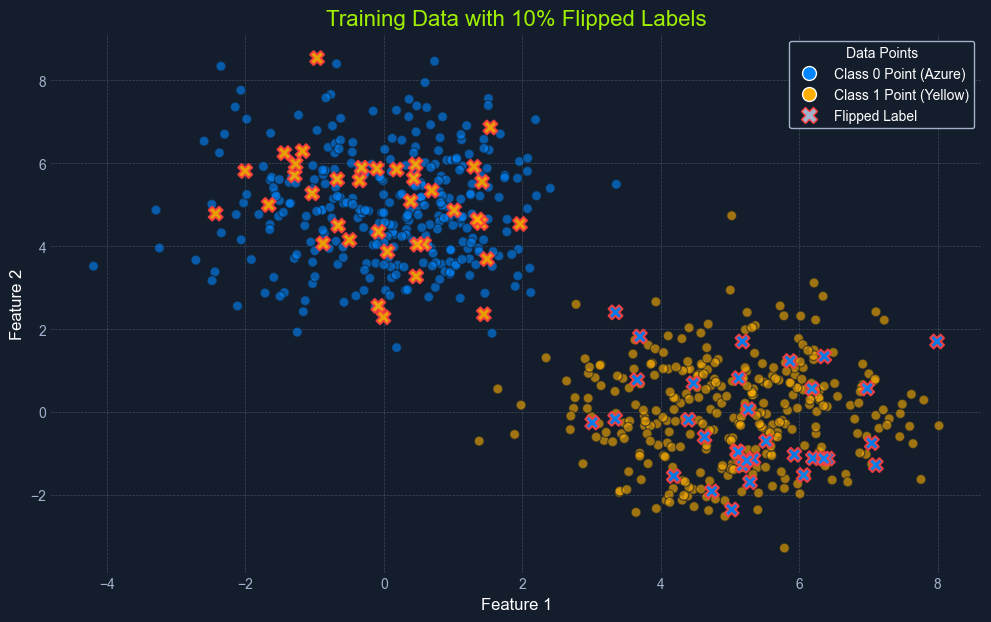

Accuracy on clean test set (10% poisoned): 0.9933


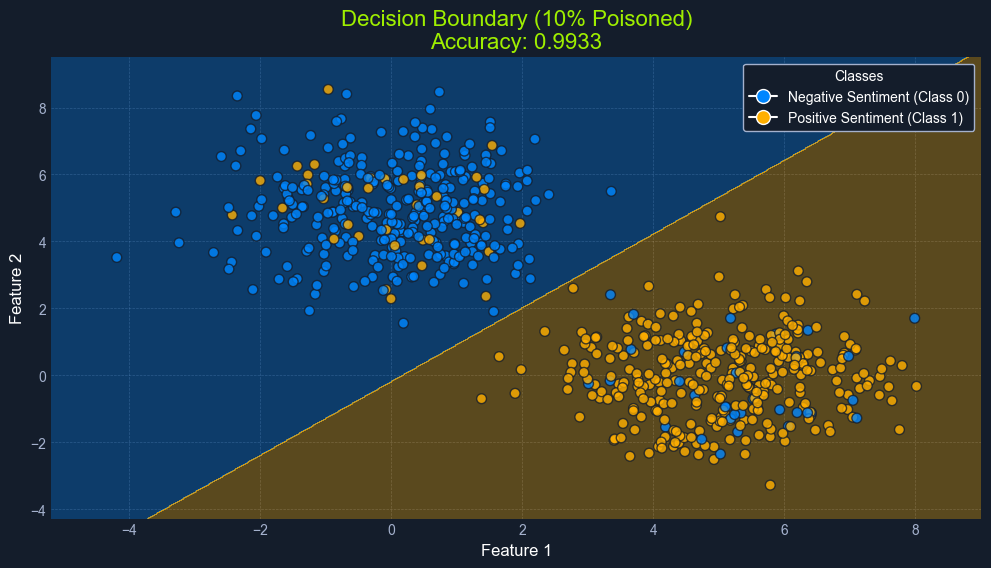

Baseline accuracy was: 0.9933


In [16]:
results = {
    "percentage": [],
    "accuracy": [],
    "model": [],
    "y_train_poisoned": [],
    "flipped_indices": [],
}
decision_boundaries_data = []  # To store data for the combined plot

# Add baseline results first
results["percentage"].append(0.0)
results["accuracy"].append(baseline_accuracy)
results["model"].append(baseline_model)
results["y_train_poisoned"].append(y_train.copy())
results["flipped_indices"].append(np.array([], dtype=int))

# Calculate meshgrid once for all boundary plots
h = 0.02  # Step size in the mesh
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Perform 10% Poisoning
poison_percentage_10 = 0.10
print(f"\n--- Testing with {poison_percentage_10 * 100:.0f}% Poisoned Data ---")

# Create 10% Poisoned Data
y_train_poisoned_10, flipped_indices_10 = flip_labels(y_train, poison_percentage_10)

# Visualize 10% Poisoned Data
plot_poisoned_data(
    X_train,
    y_train,
    y_train_poisoned_10,
    flipped_indices_10,
    title=f"Training Data with {poison_percentage_10 * 100:.0f}% Flipped Labels",
)

# Train Model on 10% Poisoned Data
model_10_percent = LogisticRegression(random_state=SEED)
model_10_percent.fit(X_train, y_train_poisoned_10)  # Train with original X, poisoned y

# Evaluate on Clean Test Data
y_pred_10_percent = model_10_percent.predict(X_test)
accuracy_10_percent = accuracy_score(y_test, y_pred_10_percent)
print(f"Accuracy on clean test set (10% poisoned): {accuracy_10_percent:.4f}")

# Store Results
results["percentage"].append(poison_percentage_10)
results["accuracy"].append(accuracy_10_percent)
results["model"].append(model_10_percent)
results["y_train_poisoned"].append(y_train_poisoned_10)
results["flipped_indices"].append(flipped_indices_10)

# Visualize Decision Boundary
plot_decision_boundary(
    model_10_percent,
    X_train,
    y_train_poisoned_10,  # Visualize boundary with poisoned labels shown
    title=f"Decision Boundary ({poison_percentage_10 * 100:.0f}% Poisoned)\nAccuracy: {accuracy_10_percent:.4f}",
)

# Store decision boundary prediction for combined plot
Z_10 = model_10_percent.predict(mesh_points)
Z_10 = Z_10.reshape(xx.shape)
decision_boundaries_data.append({"percentage": poison_percentage_10, "Z": Z_10})
print(
    f"Baseline accuracy was: {baseline_accuracy:.4f}"
)  # Print baseline for comparison

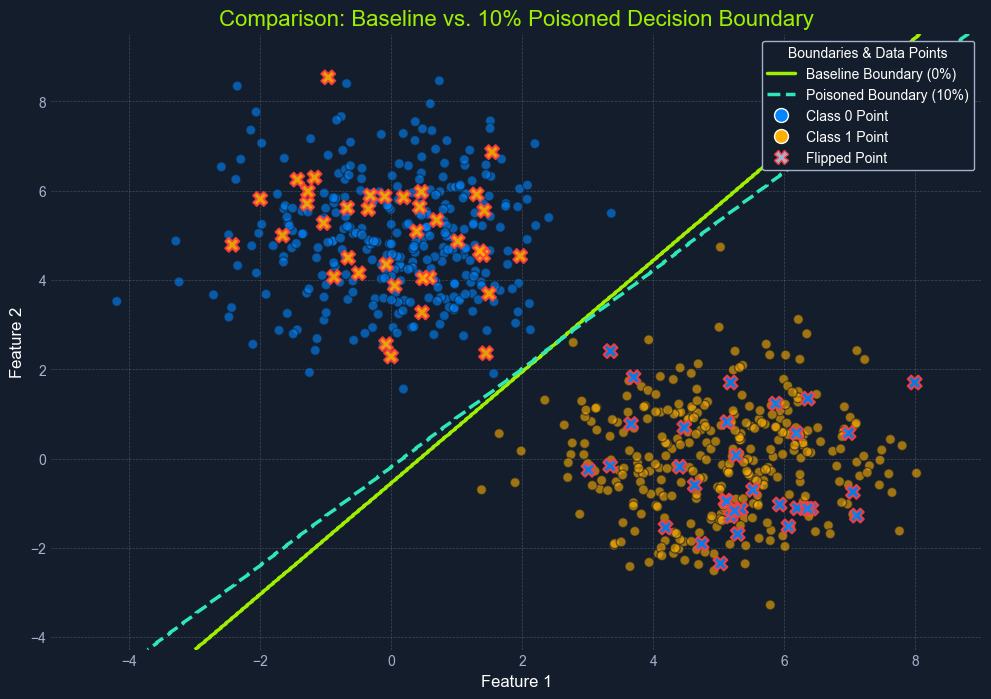

In [10]:
plt.figure(figsize=(12, 8))

# Plot the 10% poisoned data points for context
mask_not_flipped_10 = np.ones(len(y_train), dtype=bool)
mask_not_flipped_10[flipped_indices_10] = False
plt.scatter(
    X_train[mask_not_flipped_10, 0],
    X_train[mask_not_flipped_10, 1],
    c=y_train_poisoned_10[mask_not_flipped_10],
    cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
    edgecolors=node_black,
    s=50,
    alpha=0.6,
    label="Original Label (in 10% set)",
)

# Plot flipped points ('X' marker)
if len(flipped_indices_10) > 0:
    plt.scatter(
        X_train[flipped_indices_10, 0],
        X_train[flipped_indices_10, 1],
        c=y_train_poisoned_10[flipped_indices_10],  # Color by the new poisoned label
        cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
        edgecolors=malware_red,
        linewidths=1.5,
        marker="X",
        s=100,
        alpha=0.9,
        label="Flipped Label (10% set)",
    )

# Overlay Baseline Decision Boundary (Solid Green)
baseline_model_retrieved = results["model"][
    results["percentage"].index(0.0)
]  # Get baseline model
if baseline_model_retrieved:
    Z_baseline = baseline_model_retrieved.predict(mesh_points).reshape(xx.shape)
    plt.contour(
        xx,
        yy,
        Z_baseline,
        levels=[0.5],
        colors=[htb_green],
        linestyles=["solid"],
        linewidths=[2.5],
    )
else:
    print("Warning: Baseline model not found for comparison plot.")


# Overlay 10% Poisoned Decision Boundary
plt.contour(
    xx,
    yy,
    Z_10,
    levels=[0.5],
    colors=[aquamarine],
    linestyles=["dashed"],
    linewidths=[2.5],
)


plt.title(
    "Comparison: Baseline vs. 10% Poisoned Decision Boundary",
    fontsize=16,
    color=htb_green,
)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Create legend
handles = [
    plt.Line2D(
        [0],
        [0],
        color=htb_green,
        lw=2.5,
        linestyle="solid",
        label="Baseline Boundary (0%)",
    ),
    plt.Line2D(
        [0],
        [0],
        color=aquamarine,
        lw=2.5,
        linestyle="dashed",
        label="Poisoned Boundary (10%)",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 0 Point",
        markersize=10,
        markerfacecolor=azure,
        linestyle="None",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 1 Point",
        markersize=10,
        markerfacecolor=nugget_yellow,
        linestyle="None",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="X",
        color="w",
        label="Flipped Point",
        markersize=10,
        markeredgecolor=malware_red,
        markerfacecolor=hacker_grey,
        linestyle="None",
    ),
]
plt.legend(handles=handles, title="Boundaries & Data Points")
plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


--- Training with 20% Poisoned Data ---
Flipping 140 labels (20.0%).
Accuracy on clean test set: 0.9933


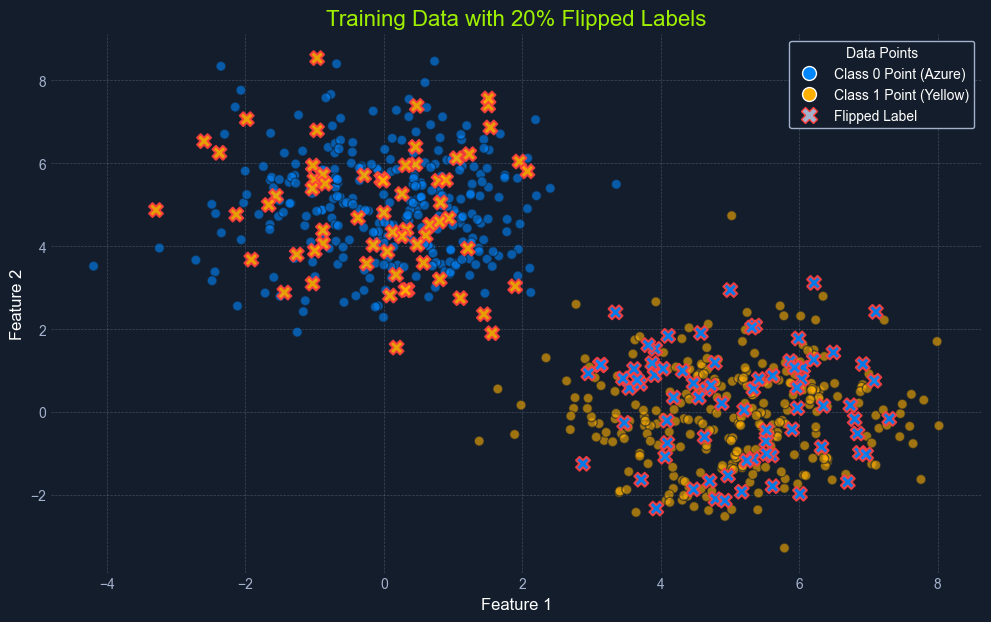

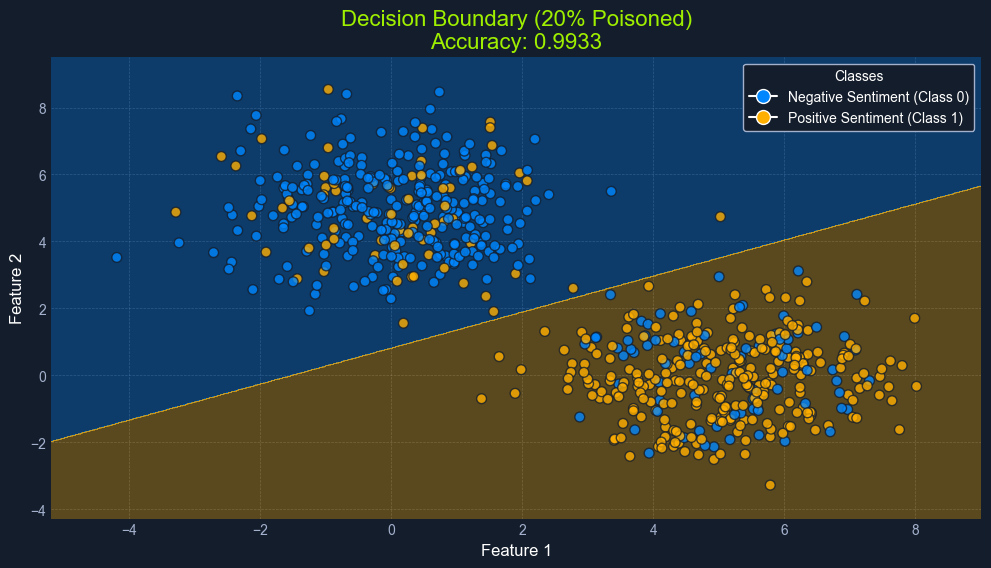


--- Training with 30% Poisoned Data ---
Flipping 210 labels (30.0%).
Accuracy on clean test set: 0.9933


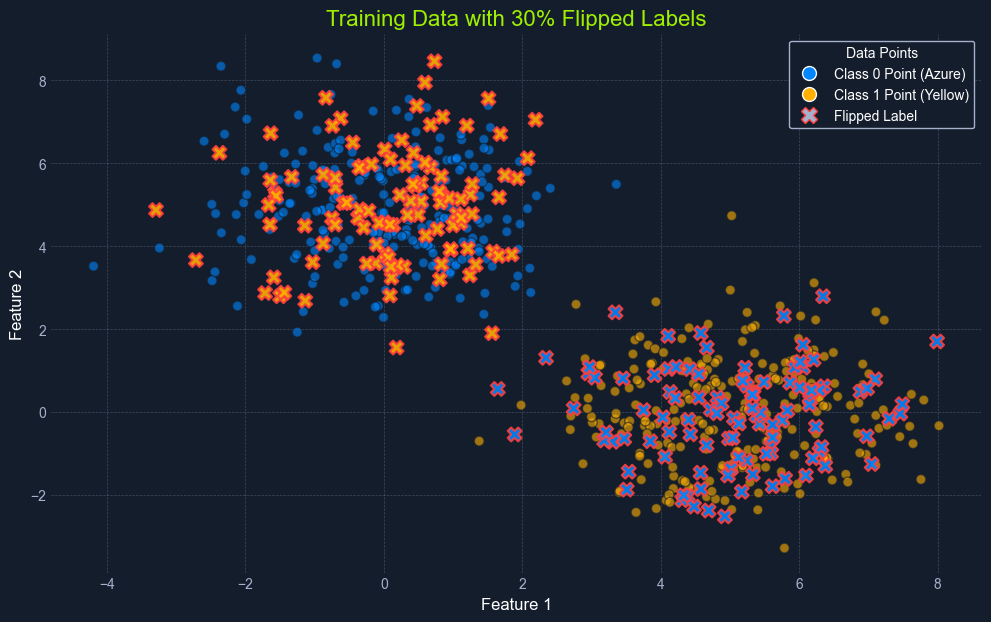

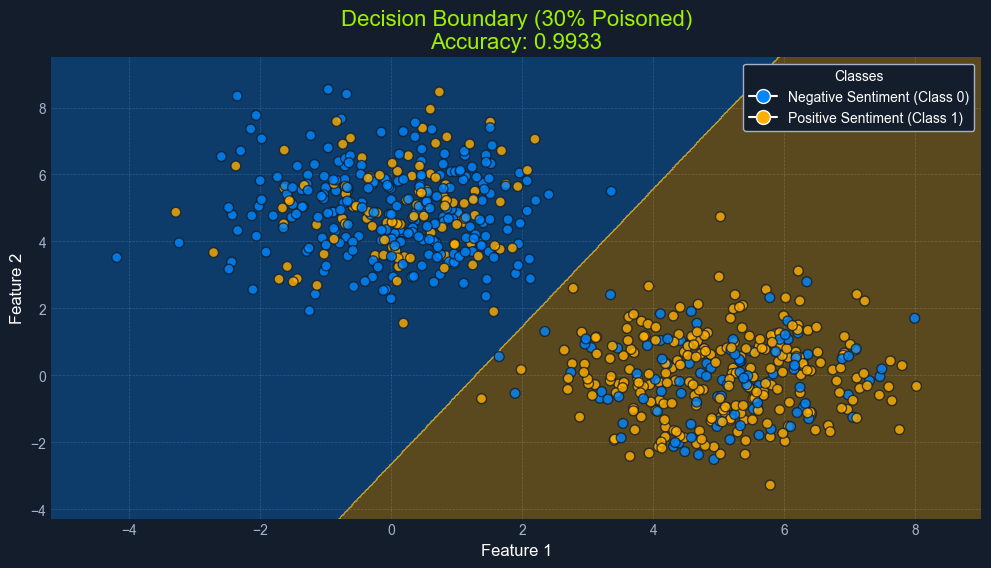


--- Training with 40% Poisoned Data ---
Flipping 280 labels (40.0%).
Accuracy on clean test set: 0.9933


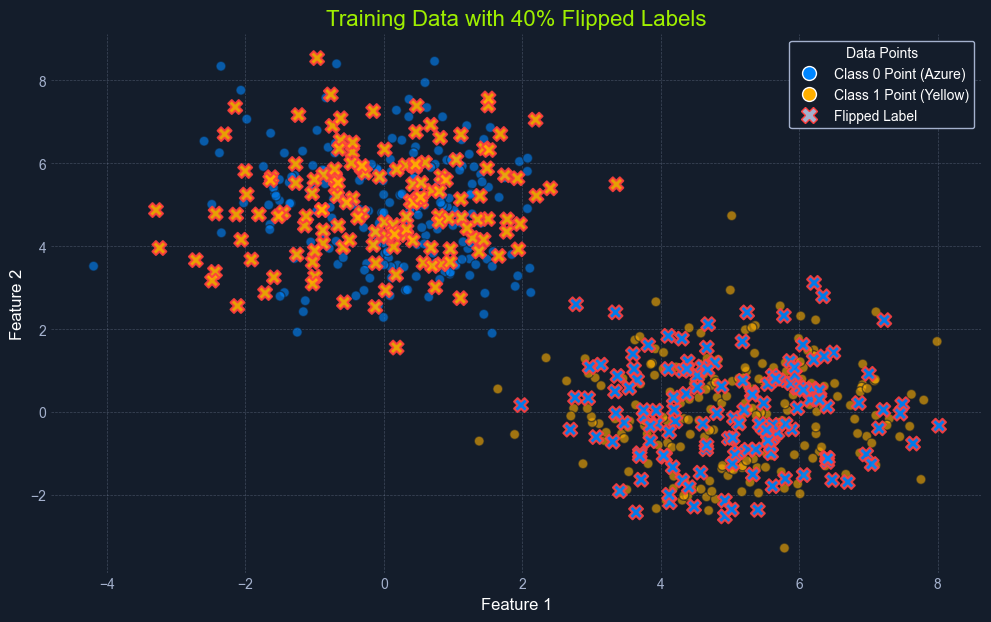

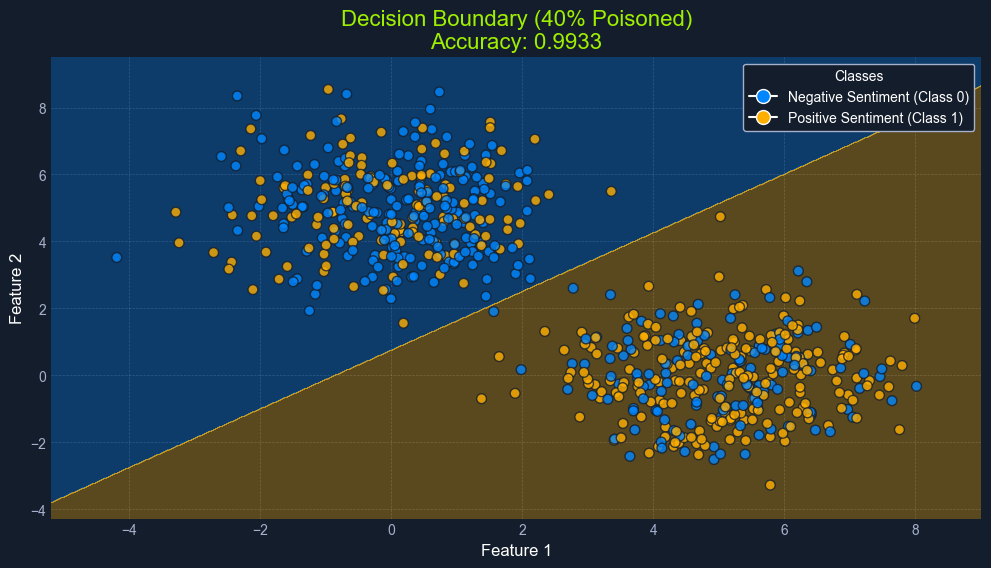


--- Training with 50% Poisoned Data ---
Flipping 350 labels (50.0%).
Accuracy on clean test set: 0.4767


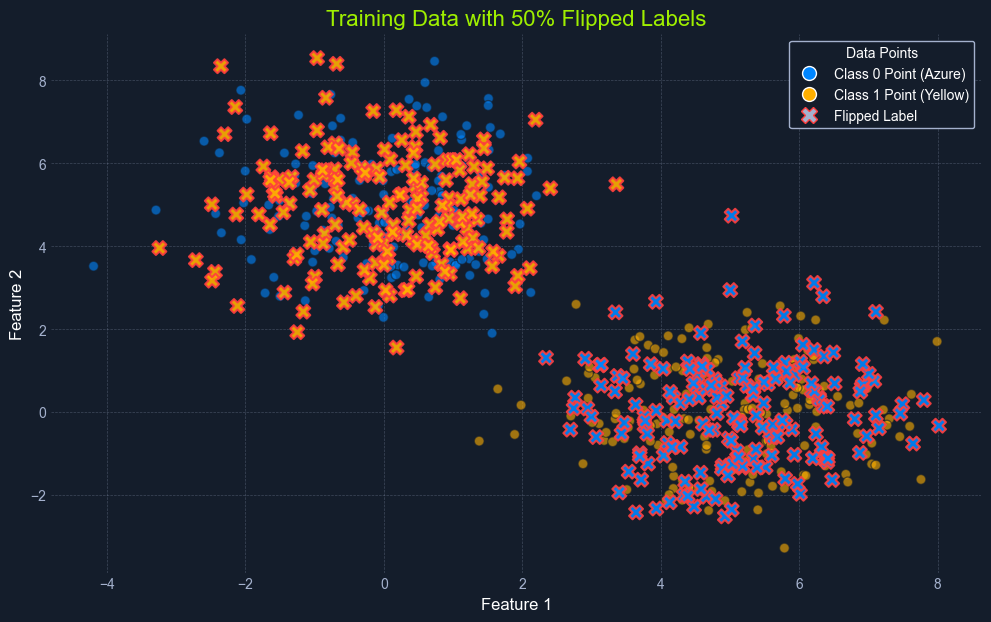

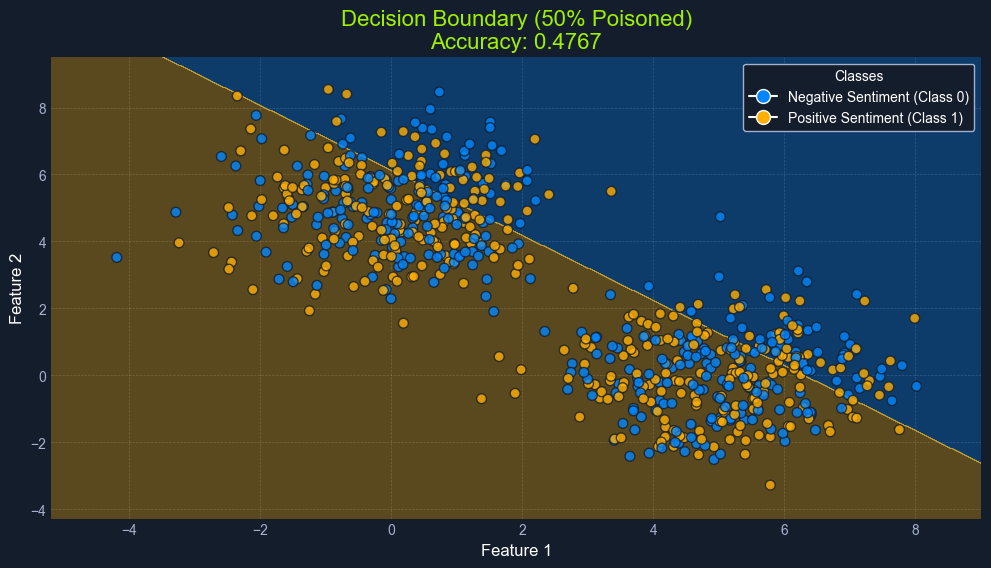


--- Evaluation Complete for Higher Percentages ---


In [11]:
poison_percentages_high = [0.20, 0.30, 0.40, 0.50]

for pp in poison_percentages_high:
    print(f"\n--- Training with {pp * 100:.0f}% Poisoned Data ---")

    # Create Poisoned Data
    y_train_poisoned, flipped_idx = flip_labels(y_train, pp)

    # Train Model on Poisoned Data
    poisoned_model = LogisticRegression(random_state=SEED)
    try:
        poisoned_model.fit(
            X_train, y_train_poisoned
        )  # Train with original X, but poisoned y
    except Exception as e:
        print(f"Error training model at {pp * 100}% poisoning: {e}")
        results["percentage"].append(pp)
        results["accuracy"].append(np.nan)  # Indicate failure
        results["model"].append(None)
        results["y_train_poisoned"].append(
            y_train_poisoned
        )  # Still store poisoned labels
        results["flipped_indices"].append(flipped_idx)  # and indices
        continue  # Skip to next percentage

    # Evaluate on Clean Test Data
    y_pred_poisoned = poisoned_model.predict(X_test)
    accuracy = accuracy_score(
        y_test, y_pred_poisoned
    )  # Always evaluate against TRUE test labels
    print(f"Accuracy on clean test set: {accuracy:.4f}")

    # Store Results
    results["percentage"].append(pp)
    results["accuracy"].append(accuracy)
    results["model"].append(poisoned_model)
    results["y_train_poisoned"].append(y_train_poisoned)
    results["flipped_indices"].append(flipped_idx)

    # Visualize Poisoned Data and Decision Boundary
    plot_poisoned_data(
        X_train,
        y_train,
        y_train_poisoned,
        flipped_idx,
        title=f"Training Data with {pp * 100:.0f}% Flipped Labels",
    )

    plot_decision_boundary(
        poisoned_model,
        X_train,
        y_train_poisoned,  # Visualize boundary with poisoned labels shown
        title=f"Decision Boundary ({pp * 100:.0f}% Poisoned)\nAccuracy: {accuracy:.4f}",
    )

    # Store decision boundary prediction for combined plot
    Z = poisoned_model.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    decision_boundaries_data.append({"percentage": pp, "Z": Z})

print("\n--- Evaluation Complete for Higher Percentages ---")

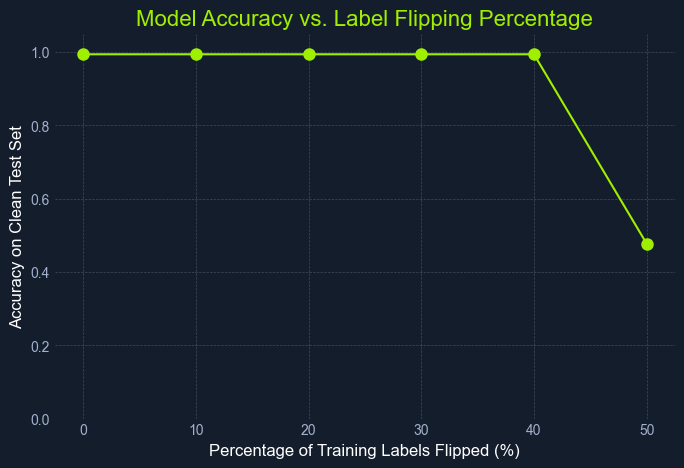

In [12]:
# Plot accuracy vs. poisoning percentage
plt.figure(figsize=(8, 5))
# Ensure percentages and accuracies are sorted correctly if the order changed for any reason
plot_data = sorted(zip(results["percentage"], results["accuracy"]))
plot_percentages = [p * 100 for p, a in plot_data]
plot_accuracies = [a for p, a in plot_data]

plt.plot(
    plot_percentages,
    plot_accuracies,
    marker="o",
    linestyle="-",
    color=htb_green,
    markersize=8,
)
plt.title("Model Accuracy vs. Label Flipping Percentage", fontsize=16, color=htb_green)
plt.xlabel("Percentage of Training Labels Flipped (%)", fontsize=12)
plt.ylabel("Accuracy on Clean Test Set", fontsize=12)
plt.xticks(plot_percentages)  # Ensure ticks match the evaluated percentages
plt.ylim(0, 1.05)
plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
plt.show()

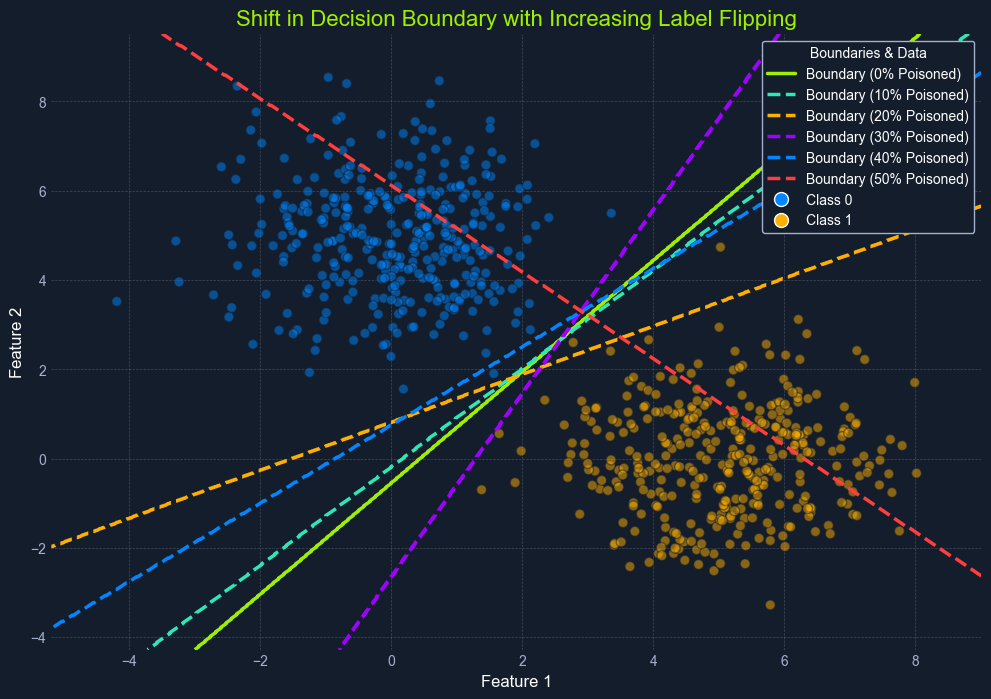

In [13]:
plt.figure(figsize=(12, 8))

# Plot the original clean data points for reference
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap=plt.cm.colors.ListedColormap([azure, nugget_yellow]),
    edgecolors=node_black,
    s=50,
    alpha=0.5,
    label="Clean Data Points",
)

contour_colors = {
    0.0: htb_green,
    0.10: aquamarine,
    0.20: nugget_yellow,
    0.30: vivid_purple,
    0.40: azure,
    0.50: malware_red,
}
contour_linestyles = {
    0.0: "solid",
    0.10: "dashed",
    0.20: "dashed",
    0.30: "dashed",
    0.40: "dashed",
    0.50: "dashed",
}

# Get baseline boundary data
baseline_model_idx = results["percentage"].index(0.0)
baseline_model_retrieved = results["model"][baseline_model_idx]
if baseline_model_retrieved:
    Z_baseline = baseline_model_retrieved.predict(mesh_points).reshape(xx.shape)
    cs = plt.contour(
        xx,
        yy,
        Z_baseline,
        levels=[0.5],
        colors=[contour_colors[0.0]],
        linestyles=[contour_linestyles[0.0]],
        linewidths=[2.5],
    )

boundary_indices_to_plot = [0.10, 0.20, 0.30, 0.40, 0.50]
plotted_percentages = [0.0]

# Sort decision_boundaries_data by percentage to ensure consistent plotting order
decision_boundaries_data.sort(key=lambda item: item["percentage"])

for data in decision_boundaries_data:
    pp = data["percentage"]
    if pp in boundary_indices_to_plot:
        if pp in contour_colors and pp in contour_linestyles:
            Z = data["Z"]
            cs = plt.contour(
                xx,
                yy,
                Z,
                levels=[0.5],
                colors=[contour_colors[pp]],
                linestyles=[contour_linestyles[pp]],
                linewidths=[2.5],
            )
            plotted_percentages.append(pp)
        else:
            print(f"Warning: Style not defined for {pp * 100}%, skipping contour.")


plt.title(
    "Shift in Decision Boundary with Increasing Label Flipping",
    fontsize=16,
    color=htb_green,
)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Create legend
legend_handles = []
for pp in sorted(plotted_percentages):
    if (
        pp in contour_colors and pp in contour_linestyles
    ):  # Check again before creating legend entry
        legend_handles.append(
            plt.Line2D(
                [0],
                [0],
                color=contour_colors[pp],
                lw=2.5,
                linestyle=contour_linestyles[pp],
                label=f"Boundary ({pp * 100:.0f}% Poisoned)",
            )
        )

# Add legend for data points as well
data_handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 0",
        markersize=10,
        markerfacecolor=azure,
        linestyle="None",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 1",
        markersize=10,
        markerfacecolor=nugget_yellow,
        linestyle="None",
    ),
]

plt.legend(handles=legend_handles + data_handles, title="Boundaries & Data")
plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

***

## Targeted Label Attacks

In [7]:
def targeted_flip_labels(y, poison_percentage, target_class, new_class, seed=1337):

    if not 0 <= poison_percentage <= 1:
        raise ValueError("poison_percentage must be between 0 and 1.")
    if target_class == new_class:
        raise ValueError("target_class and new_class cannot be the same.")
    # Ensure target_class and new_class are present in y
    unique_labels = np.unique(y)
    if target_class not in unique_labels:
         raise ValueError(f"target_class ({target_class}) does not exist in y.")
    if new_class not in unique_labels:
         raise ValueError(f"new_class ({new_class}) does not exist in y.")
    # Identify indices belonging to the target class
    target_indices = np.where(y == target_class)[0]
    n_target_samples = len(target_indices)

    if n_target_samples == 0:
        print(f"Warning: No samples found for target_class {target_class}. No labels flipped.")
        return y.copy(), np.array([], dtype=int)

    # Calculate the number of labels to flip within the target class
    n_to_flip = int(n_target_samples * poison_percentage)

    if n_to_flip == 0:
        print(f"Warning: Poison percentage ({poison_percentage * 100:.1f}%) is too low "
              f"to flip any labels in the target class (size {n_target_samples}).")
        return y.copy(), np.array([], dtype=int)

    # Use a dedicated random number generator instance with the specified seed
    rng_instance = np.random.default_rng(seed)

    # Randomly select indices from the target_indices subset to flip
    # These are indices relative to the target_indices array
    indices_within_target_set_to_flip = rng_instance.choice(
        n_target_samples, size=n_to_flip, replace=False
    )
    # Map these back to the original array indices
    flipped_indices = target_indices[indices_within_target_set_to_flip]
    # Create a copy to avoid modifying the original array
    y_poisoned = y.copy()

    # Perform the flip for the selected indices to the new class label
    y_poisoned[flipped_indices] = new_class
    print(f"Targeting Class {target_class} for flipping to Class {new_class}.")
    print(f"Identified {n_target_samples} samples of Class {target_class}.")
    print(f"Attempting to flip {poison_percentage * 100:.1f}% ({n_to_flip} samples) of these.")
    print(f"Successfully flipped {len(flipped_indices)} labels.")
    return y_poisoned, flipped_indices

Targeting Class 1 for flipping to Class 0.
Identified 353 samples of Class 1.
Attempting to flip 40.0% (141 samples) of these.
Successfully flipped 141 labels.

--- Visualizing Targeted Poisoned Data ---


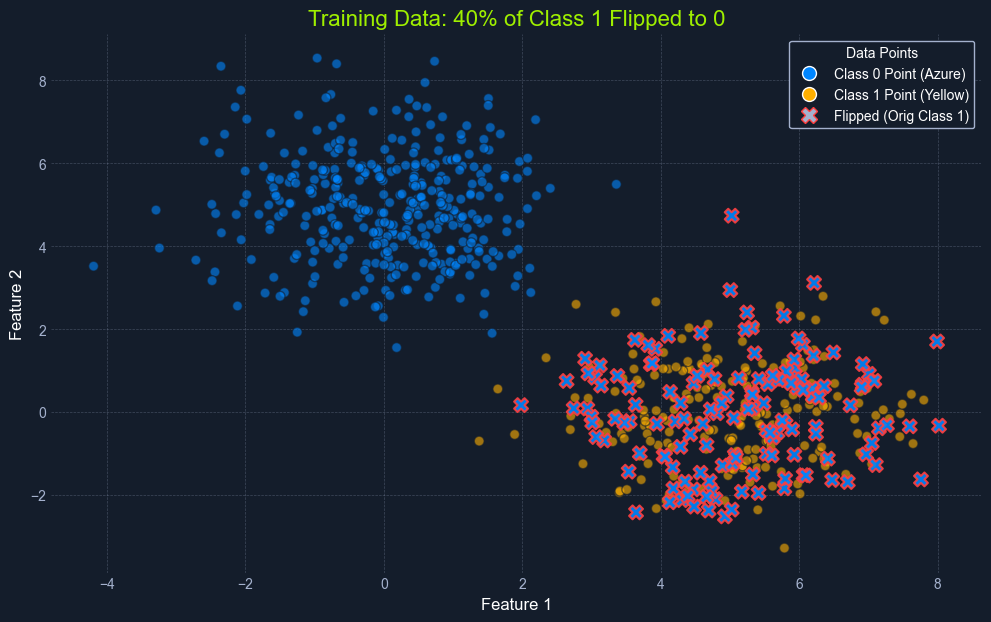

In [8]:
poison_percentage_targeted = 0.40  # Target 40%
target_class_to_flip = 1  # Target Class 1 (Positive)
new_label_for_flipped = 0  # Flip them to Class 0 (Negative)

# Use the function to create the poisoned dataset
y_train_targeted_poisoned, targeted_flipped_indices = targeted_flip_labels(
    y_train,
    poison_percentage_targeted,
    target_class_to_flip,
    new_label_for_flipped,
    seed=SEED,  # Use the global SEED for reproducibility
)

print("\n--- Visualizing Targeted Poisoned Data ---")
# Plot the result of the targeted flip
plot_poisoned_data(
    X_train,
    y_train,  # Pass original y
    y_train_targeted_poisoned,
    targeted_flipped_indices,
    title=f"Training Data: {poison_percentage_targeted * 100:.0f}% of Class {target_class_to_flip} Flipped to {new_label_for_flipped}",
    target_class_info=target_class_to_flip,
)

In [9]:
targeted_poisoned_model = LogisticRegression(random_state=SEED)
targeted_poisoned_model.fit(X_train, y_train_targeted_poisoned)

LogisticRegression(random_state=1337)


--- Evaluating Targeted Poisoned Model ---
Accuracy on clean test set: 0.8100
Baseline accuracy was: 0.9933

Classification Report on Clean Test Set:
              precision    recall  f1-score   support

     Class 0       0.73      1.00      0.84       153
     Class 1       1.00      0.61      0.76       147

    accuracy                           0.81       300
   macro avg       0.86      0.81      0.80       300
weighted avg       0.86      0.81      0.80       300



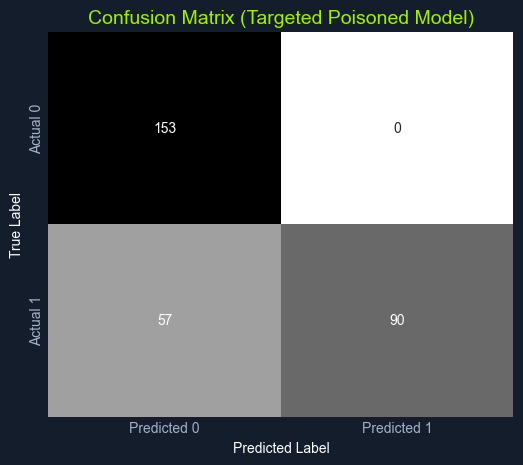

In [12]:
# Predict on the original, clean test set
y_pred_targeted = targeted_poisoned_model.predict(X_test)

# Calculate accuracy on the clean test set
targeted_accuracy = accuracy_score(y_test, y_pred_targeted)
print(f"\n--- Evaluating Targeted Poisoned Model ---")
print(f"Accuracy on clean test set: {targeted_accuracy:.4f}")
print(f"Baseline accuracy was: {baseline_accuracy:.4f}")

# Display classification report
print("\nClassification Report on Clean Test Set:")
print(
    classification_report(y_test, y_pred_targeted, target_names=["Class 0", "Class 1"])
)

# Plot confusion matrix
cm_targeted = confusion_matrix(y_test, y_pred_targeted)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_targeted,
    annot=True,
    fmt="d",
    cmap="binary",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
    cbar=False,
)
plt.xlabel("Predicted Label", color=white)
plt.ylabel("True Label", color=white)
plt.title("Confusion Matrix (Targeted Poisoned Model)", fontsize=14, color=htb_green)
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
plt.show()

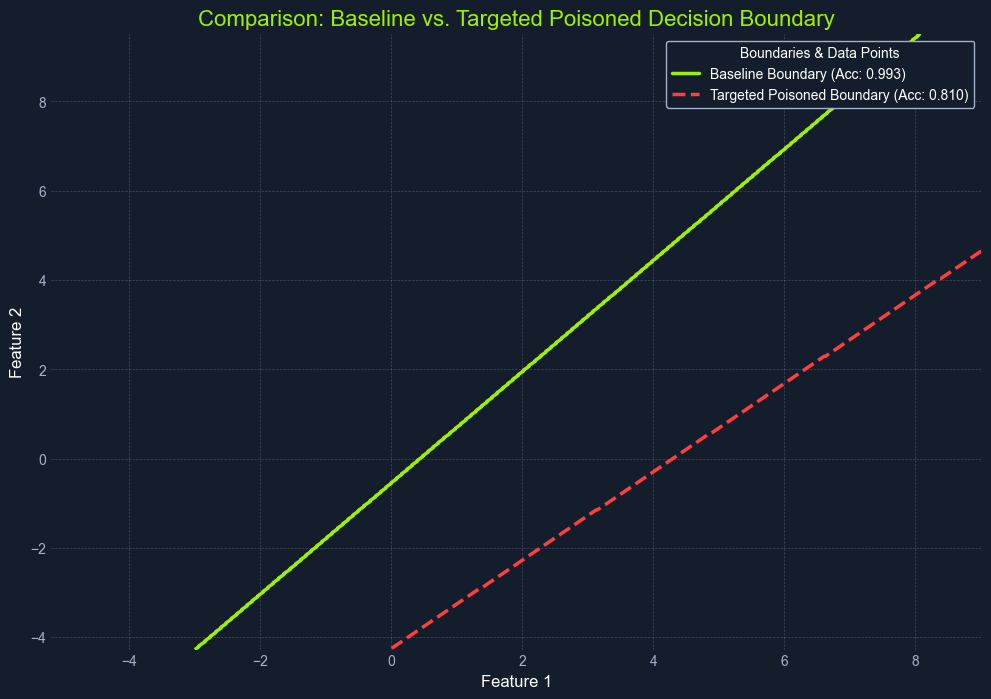

In [17]:
# Plot the comparison of decision boundaries
plt.figure(figsize=(12, 8))

# Plot Baseline Decision Boundary (Solid Green)
Z_baseline = baseline_model.predict(mesh_points).reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z_baseline,
    levels=[0.5],
    colors=[htb_green],
    linestyles=["solid"],
    linewidths=[2.5],
)

# Plot Targeted Poisoned Decision Boundary (Dashed Red)
Z_targeted = targeted_poisoned_model.predict(mesh_points).reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z_targeted,
    levels=[0.5],
    colors=[malware_red],
    linestyles=["dashed"],
    linewidths=[2.5],
)

plt.title(
    "Comparison: Baseline vs. Targeted Poisoned Decision Boundary",
    fontsize=16,
    color=htb_green,
)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Create legend combining data points and boundaries
handles = [
    plt.Line2D(
        [0],
        [0],
        color=htb_green,
        lw=2.5,
        linestyle="solid",
        label=f"Baseline Boundary (Acc: {baseline_accuracy:.3f})",
    ),
    plt.Line2D(
        [0],
        [0],
        color=malware_red,
        lw=2.5,
        linestyle="dashed",
        label=f"Targeted Poisoned Boundary (Acc: {targeted_accuracy:.3f})",
    ),
]

plt.legend(handles=handles, title="Boundaries & Data Points")
plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()